In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.special import sph_harm
from scipy.optimize import fsolve

%run ExoTides_analytic.ipynb # get analytic model functions

In [11]:
def pressure(phi_int, p_data, lam):
    # phi_int = longitude evaluated by integral
    # allow interpolation of pressure field for integration
    return(np.interp(phi_int, lam, p_data)) 

def complex_mom_pressure(m, p_data, x_data):
    # perform spherical harmonic decomposition of surface pressure field (l = 2, m =+- 2)
    # p_data = pressure field from simple model
    # x_data = longitude list from simple model
    
    ## quad() ignores imaginary part, so decompose integral into real and imaginary part and then recombine
    p2_imag = quad(lambda phi: np.imag(np.conj(sph_harm(m,2,phi,np.pi/2))) * pressure(phi, p_data, x_data), 0, 2*np.pi)[0] # Equation (5), tilde(p_2)
    p2_real = quad(lambda phi: np.real(np.conj(sph_harm(m,2,phi,np.pi/2))) * pressure(phi, p_data, x_data), 0, 2*np.pi)[0]
    return(p2_real + 1j*p2_imag)

def torque_info(ps, x_data, p_avg): # returns torque, amplitude, and lag
    # data = pressure field from simple model
    # x_data = longitude list from simple model
    p22 = complex_mom_pressure(2, np.array(ps), x_data) # m = 2
    p2m2 = complex_mom_pressure(-2, np.array(ps), x_data) # m = -2
    arg = np.arctan(np.imag(p22)/np.real(p22)) # argument of p22 is delta_a
    lag = np.sin(2*0 - arg)
    amp = np.absolute(p22)
    im_qa = np.imag(p22)
    return([amp, im_qa, lag])

#### From Equation (7):
\begin{equation}\label{eq:dTdt}
    C\frac{dT(\lambda)}{dt} = S_o(1-\alpha(\lambda))e^{-\tau_{SW}}f(\lambda,t) - \sigma_{SB}T(\lambda)^4 + F_{LW},
\end{equation} 

To save computation time, note that $\lambda_* = \sigma t$ and perform a change of variables:
\begin{equation}
C\sigma\frac{dT}{d\lambda} = S_o(1-\alpha) e^{-\tau_{SW}}f(\lambda) - \sigma_{SB}T^4 + F_{LW},
\end{equation}
where $f(\lambda) = max\left[\cos(\lambda),0\right]$ and,
\begin{equation}
    F_{LW} = \frac{S_o(1-\alpha)}{2}\left[1 + Dk^{-1} - (1+Dk^{-1})e^{-k\tau_{LW}}\right].
\end{equation}

In [5]:
def T_lam_locked(T, lam, S, tau_lw, tau_sw, SLW): # for zero forcing, use fsolve on Equation (7) to solve at each longitude
    return((S*np.exp(-tau_sw)*np.maximum(np.cos(lam),0) - sigma_SB*T**4  + SLW)) 

def do_T_lam_locked(tau_lw, tau_sw, S_in, lam_plot, alpha, guess):
    lam_list = np.linspace(0, 2*np.pi, 200)
    sol = np.zeros(len(lam_list))
    k = tau_sw/tau_lw
    SLW = S_in*(1-alpha)/8*(1+D/k - (1+D/k)*np.exp(-k*tau_lw)) # surface downwelling longwave [Wm-2]
    j = 0
    for lam in lam_list:
        sol[j] = fsolve(T_lam_locked, guess, args = (lam, S_in*(1-alpha), tau_lw, tau_sw, SLW)) # get Ts for each longitude
        j +=1
    return(np.interp(lam_plot,lam_list, sol)) # interpolate so solution is same length as others

def dTdlam(lam, T, phi, forcing, Cs, S, tau_lw, SLW): # Equation (7) with change of variables described above, used for non-zero forcing (not locked)
    cos_zenith = np.cos(lam)
    return((S*np.maximum(cos_zenith,0) - sigma_SB*T**4  + SLW)/(forcing*Cs)) # dTdt = F_in - F_out

def T_lam_centered(forcing, ps, S_in, periods_needed, res, N_cycles, tau_sw, tau_lw,alpha, guess): # solve Equation (7), with substellar the origin of longitudes
    S_model = S_in*(1-alpha)*np.exp(-tau_sw) # surface absorbed stellar radiation [Wm-2]
    k = tau_sw/tau_lw 
    F_bar = S_in*(1-alpha)*np.exp(-tau_sw)/np.pi # average incident stellar radiation at surface (Wm-2)
    SLW = S_in*(1-alpha)/8*(1+D/k - (1+D/k)*np.exp(-k*tau_lw)) # surface downwelling longwave (Wm-2), Equation (15)
    T_bar = np.power((F_bar+SLW)/sigma_SB, 1/4) # average surface temperature (K)
    T_eq = (S_in*(1-alpha)/(4*sigma_SB))**(1/4) # equilibrium temperature (K)
    Us = wind_speed(S_in, alpha, tau_sw, tau_lw, ps)
    delt_p = 0.17*ps*Us/Uso
    Cs = delt_p/g * cp + Cs_land
    if forcing > 0: # super-syncronous (sigma +)
        lam_list = np.linspace(0, 2*np.pi, res)
        lam_list_full = np.linspace(0, (periods_needed+N_cycles)*(2*np.pi), res*(periods_needed+N_cycles))
    elif forcing < 0: # sub-syncronous (sigma -)
        lam_list = np.linspace(2*np.pi,0, res)
        lam_list_full = np.linspace((periods_needed+N_cycles)*(2*np.pi), 0, res*(periods_needed+N_cycles))
    lammin = lam_list[0]
    lammax = lam_list[-1]
    T0 = T_bar*1 # initial guess for Ts    
    sol = odeint(dTdlam, T0, lam_list_full,args = (0, forcing, Cs, S_model, tau_lw, SLW), tfirst=True) # solve dTdlam
    sol_stacked = np.reshape(sol, [N_cycles+periods_needed, res])
    avg_stacked_ts = np.nanmean(sol_stacked[-N_cycles:,:], axis = 0) # average over last N periods
    sorted_index = np.argsort(lam_list)
    ## calculate ps from Ts
    avg_stacked_ps = ps - delt_p*(avg_stacked_ts-T_bar)/T_bar 
    return(avg_stacked_ts[sorted_index],avg_stacked_ps[sorted_index])


In [6]:
def run_ExoTides(tau_lw, tau_sw, ps, n,res, periods_needed, S_in, alpha, Omega_list, guess):
    N_cycles = 40 # number of periods to average over
    lam_plot = np.linspace(0, 2*np.pi, res) # initialize longitude list
    sol = np.zeros([len(Omega_list), 2,len(lam_plot)])
    for i in range(len(Omega_list)):
        Omega = Omega_list[i]
        forcing = Omega-n # sigma = Omega - n
        if np.isclose(forcing,0, rtol = 1e-2): # if tidally locked (sigma=0)
            sol[i,:,:] = do_T_lam_locked(tau_lw, tau_sw, S_in, lam_plot, alpha, guess)
        else:
            sol[i,:,:] = T_lam_centered(forcing, ps, S_in, periods_needed, res, N_cycles, tau_sw, tau_lw, alpha,guess)
    return(sol)


### Sample solution: exploring effect of increased rotation rate following Leconte et al. (2015)

In [7]:
Omega_list = np.linspace(-15*n, 15*n, 31)

sol_spinup = run_ExoTides(1, 0.00001, 1*bar, n,1000, 400, 1137, 0.2, Omega_list, 300)

Text(0.5, 0, 'Longitude (radians)')

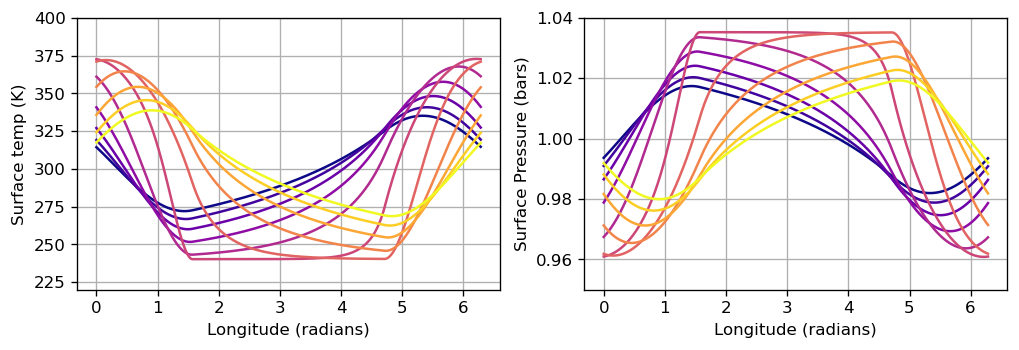

In [9]:
plt.rcParams['axes.prop_cycle'] = plt.cycler("color", plt.cm.plasma(np.linspace(0,1,11)))
fig, ax = plt.subplots(1,2,figsize = (10,3),dpi=120)
lam_list = np.linspace(0, 2*np.pi,len(sol_spinup[0,0,:]))
for i in range(0,len(Omega_list),3):
    ax[0].plot(lam_list, sol_spinup[i, 0,:])
    ax[1].plot(lam_list, sol_spinup[i, 1,:]/bar)
    
    
ax[0].grid()
ax[1].grid()
ax[0].set_ylim(220,400)
ax[0].set_ylabel('Surface temp (K)')
ax[0].set_xlabel('Longitude (radians)')

ax[1].set_ylim(0.95,1.04)
ax[1].set_ylabel('Surface Pressure (bars)')
ax[1].set_xlabel('Longitude (radians)')

## Plot resulting torque and compare to analytic solution

<ipython-input-11-975ef51f0f1c>:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  p2_real = quad(lambda phi: np.real(np.conj(sph_harm(m,2,phi,np.pi/2))) * pressure(phi, p_data, x_data), 0, 2*np.pi)[0]
<ipython-input-11-975ef51f0f1c>:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  p2_imag = quad(lambda phi: np.imag(np.conj(sph_harm(m,2,phi,np.pi/2))) * pressure(phi, p_data, x_data), 0, 2*np.pi)[0] # Equation (5), tilde(p_2)
<ipython-input-11-975ef51f0f1c>:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, disconti

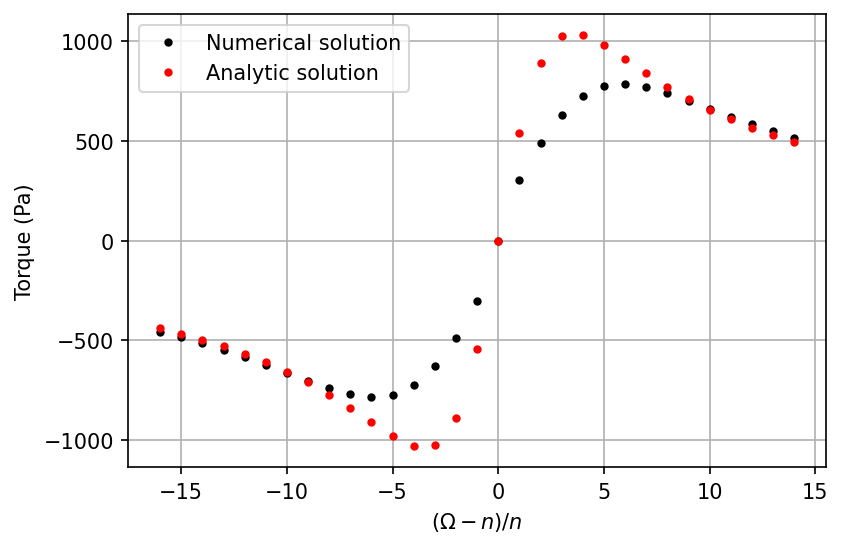

In [14]:
plt.figure(dpi=150)
for i in range(len(Omega_list)):
    if i == 0:
        plt.plot((Omega_list[i]-n)/n, torque_info(sol_spinup[i,1,:],lam_list, 1*bar)[1], 'k.', label = 'Numerical solution')
    else:
        plt.plot((Omega_list[i]-n)/n, torque_info(sol_spinup[i,1,:],lam_list, 1*bar)[1], 'k.')

plt.plot((Omega_list-n)/n, torque_analytic(1137, 0.2, 0.00001, 1, 1*bar, Omega_list, n), 'r.', label = 'Analytic solution')


plt.ylabel('Torque (Pa)')
plt.xlabel('$(\\Omega-n)/n$')
plt.legend()
plt.grid()